In [1]:
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import osmnx as ox

In [1]:
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import osmnx as ox

In [2]:
url = "http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson"
gdf = gpd.read_file(url)
gdf.head()

,OBJECTID_1,OBJECTID,DIST_NAME,ABBREV,Shape__Area,Shape__Length,PlanningDist,DaytimePop,geometry
0,1,14,River Wards,RW,2.107270e+08,66931.595020,NaN,NaN,"POLYGON ((-75.09798 40.00496, -75.09687 40.005..."
1,2,3,North Delaware,NDEL,2.700915e+08,89213.074378,NaN,NaN,"POLYGON ((-74.98159 40.05363, -74.98139 40.053..."
2,3,0,Lower Far Northeast,LFNE,3.068529e+08,92703.285159,NaN,NaN,"POLYGON ((-74.96443 40.11728, -74.96434 40.117..."
3,4,9,Central,CTR,1.782880e+08,71405.143450,NaN,NaN,"POLYGON ((-75.14791 39.96733, -75.14715 39.967..."
4,5,10,University Southwest,USW,1.296468e+08,65267.676141,NaN,NaN,"POLYGON ((-75.18742 39.96338, -75.18644 39.963..."


In [3]:
is_central = gdf[gdf['DIST_NAME']=='Central']
central = is_central['geometry'].iloc[0]

In [4]:
st = ox.graph_from_polygon(central, network_type="drive")

In [5]:
stedge = ox.graph_to_gdfs(st, edges=True, nodes=False)

In [6]:
c20 = pd.read_csv("./data/CRASH_PHILADELPHIA_2020.csv")
c21 = pd.read_csv("./data/CRASH_PHILADELPHIA_2021.csv")
c22 = pd.read_csv("./data/CRASH_PHILADELPHIA_2022.csv")
cr = pd.concat([c20, c21, c22])

In [7]:
cr = cr.dropna(subset=["DEC_LAT","DEC_LONG"])

In [8]:
cr["geometry"] = gpd.points_from_xy(cr["DEC_LONG"], cr["DEC_LAT"])
cr.head()
crgdf = gpd.GeoDataFrame(cr, geometry="geometry", crs="EPSG:4326")
crgdf.head()

,CRN,ARRIVAL_TM,AUTOMOBILE_COUNT,BELTED_DEATH_COUNT,BELTED_SUSP_SERIOUS_INJ_COUNT,BICYCLE_COUNT,BICYCLE_DEATH_COUNT,BICYCLE_SUSP_SERIOUS_INJ_COUNT,BUS_COUNT,CHLDPAS_DEATH_COUNT,...,WORKERS_PRES,WZ_CLOSE_DETOUR,WZ_FLAGGER,WZ_LAW_OFFCR_IND,WZ_LN_CLOSURE,WZ_MOVING,WZ_OTHER,WZ_SHLDER_MDN,WZ_WORKERS_INJ_KILLED,geometry
0,2020036588,1349.0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.17940 39.96010)
1,2020036617,1842.0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.20650 39.98090)
2,2020035717,2000.0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.16910 39.92690)
3,2020034378,1139.0,2,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.19240 39.92370)
4,2020025511,345.0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.24500 39.88260)


In [9]:
bd = stedge.geometry.unary_union.convex_hull
cra = crgdf.loc[crgdf.within(bd)]

In [10]:
street = ox.project_graph(st, to_crs="EPSG:2272")
crash = cra.to_crs("EPSG:2272")

In [11]:
ID = ox.distance.nearest_edges(street, crash.geometry.x, crash.geometry.y, interpolate=None, return_dist=False)

In [12]:
IDdf = pd.DataFrame(ID)
crash["u"] = IDdf[0]
crash["v"] = IDdf[1]

In [13]:
grouped = crash.groupby(["u","v"], as_index=False)["CRN"].count()

In [41]:
grouped.rename(columns = {'CRN':'crash_count'}, inplace = True)
df = pd.DataFrame(grouped)
df.set_index(['u','v'],inplace=True)
df.head()

crash_count
u           v                        
109729474.0 3.425015e+09            1
109729486.0 1.103421e+08            3
109729699.0 1.098117e+08            2
109729709.0 1.097297e+08            4
            1.098117e+08            2

In [42]:
stedge.head()

osmid  oneway                   name  \
u         v         key                                             
109727439 109911666 0    132508434    True      Bainbridge Street   
109727448 109727439 0     12109011    True  South Colorado Street   
          110034229 0     12159387    True       Fitzwater Street   
109727507 110024052 0    193364514    True       Carpenter Street   
109728761 110274344 0    672312336    True           Brown Street   

                             highway reversed   length  \
u         v         key                                  
109727439 109911666 0    residential    False   44.137   
109727448 109727439 0    residential    False  109.484   
          110034229 0    residential    False   91.353   
109727507 110024052 0    residential    False   53.208   
109728761 110274344 0    residential    False   58.270   

                                                                  geometry  \
u         v         key                                                      
109727439 109911666 0    LINESTRING (-75.17104 39.94345, -75.17053 39.9...   
109727448 109727439 0    LINESTRING (-75.17125 39.94248, -75.17120 39.9...   
          110034229 0    LINESTRING (-75.17125 39.94248, -75.17137 39.9...   
109727507 110024052 0    LINESTRING (-75.17196 39.93973, -75.17134 39.9...   
109728761 110274344 0    LINESTRING (-75.17317 39.96951, -75.17250 39.9...   

                        maxspeed lanes bridge  ref tunnel width service  \
u         v         key                                                   
109727439 109911666 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109727448 109727439 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
          110034229 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109727507 110024052 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109728761 110274344 0     25 mph   NaN    NaN  NaN    NaN   NaN     NaN   

                        access junction  
u         v         key                  
109727439 109911666 0      NaN      NaN  
109727448 109727439 0      NaN      NaN  
          110034229 0      NaN      NaN  
109727507 110024052 0      NaN      NaN  
109728761 110274344 0      NaN      NaN

In [132]:
stcra = pd.merge(stedge, df, left_index=True, right_index=True)
stcra = stcra.fillna(0)

In [133]:
stcra

osmid  \
u           v           key                                              
109729474   3425014859  0                                     62154356   
109729486   110342146   0                       [12169305, 1052694387]   
109729699   109811674   0          [1047787360, 424804073, 1047787359]   
109729709   109729731   0                                     41959235   
            109811681   0                                     12166069   
...                                                                ...   
9067729456  110254689   0                                    980227100   
9244049904  634779465   0                                     41957019   
10674041689 10674041689 0                                   1116747275   
                        1                                   1116747275   
11144117753 109729699   0    [367831920, 50725362, 61756380, 12189165]   

                             oneway                          name  \
u           v           key                                         
109729474   3425014859  0      True                   Arch Street   
109729486   110342146   0      True  North Independence Mall East   
109729699   109811674   0      True             Callowhill Street   
109729709   109729731   0      True              North 5th Street   
            109811681   0     False                 Willow Street   
...                             ...                           ...   
9067729456  110254689   0     False                  Ridge Avenue   
9244049904  634779465   0      True          Spring Garden Street   
10674041689 10674041689 0     False                   Arch Street   
                        1     False                   Arch Street   
11144117753 109729699   0      True              North 5th Street   

                                 highway reversed   length  \
u           v           key                                  
109729474   3425014859  0      secondary    False  126.087   
109729486   110342146   0      secondary    False  123.116   
109729699   109811674   0          trunk    False  135.769   
109729709   109729731   0      secondary    False  286.776   
            109811681   0    residential    False  135.689   
...                                  ...      ...      ...   
9067729456  110254689   0      secondary    False  140.654   
9244049904  634779465   0        primary    False   20.035   
10674041689 10674041689 0       tertiary    False   59.612   
                        1       tertiary     True   59.612   
11144117753 109729699   0      secondary    False  470.874   

                                                                      geometry  \
u           v           key                                                      
109729474   3425014859  0    LINESTRING (-75.14847 39.95259, -75.14859 39.9...   
109729486   110342146   0    LINESTRING (-75.14832 39.95333, -75.14813 39.9...   
109729699   109811674   0    LINESTRING (-75.14724 39.95779, -75.14739 39.9...   
109729709   109729731   0    LINESTRING (-75.14714 39.95860, -75.14712 39.9...   
            109811681   0    LINESTRING (-75.14714 39.95860, -75.14788 39.9...   
...                                                                        ...   
9067729456  110254689   0    LINESTRING (-75.15891 39.96382, -75.15898 39.9...   
9244049904  634779465   0    LINESTRING (-75.13708 39.96018, -75.13730 39.9...   
10674041689 10674041689 0    LINESTRING (-75.17821 39.95627, -75.17826 39.9...   
                        1    LINESTRING (-75.17821 39.95627, -75.17827 39.9...   
11144117753 109729699   0    LINESTRING (-75.14814 39.95362, -75.14807 39.9...   

                            maxspeed   lanes bridge ref tunnel width service  \
u           v           key                                                    
109729474   3425014859  0     25 mph       2      0   0      0     0       0   
109729486   110342146   0          0  [3, 2]      0   0      0     0       0   
109729699 

In [134]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [135]:
stcra['crash_index'] = NormalizeData(np.log10(stcra['crash_count'] / stcra['length']))

Text(0.5, 1.0, 'crash index of center city, Philadlephia')

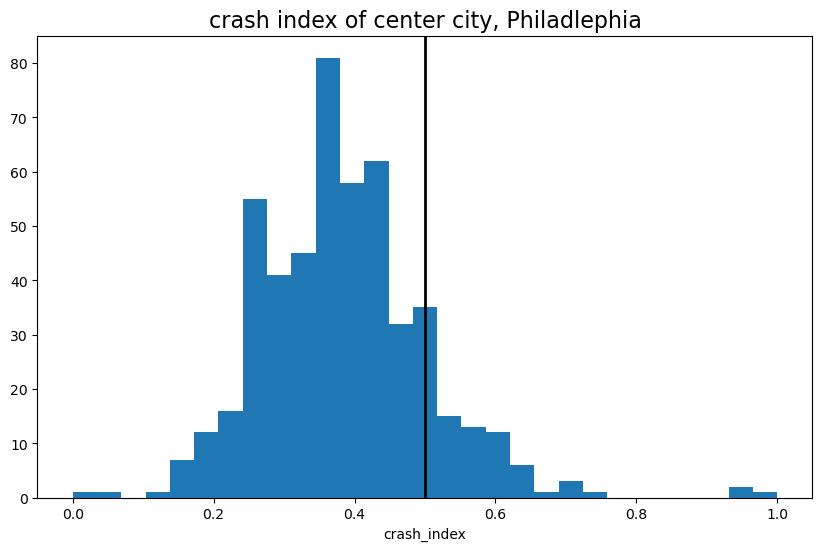

In [136]:
fig, ax = plt.subplots(figsize=(10, 6))

# histogram
ax.hist(stcra["crash_index"], bins="auto")
ax.axvline(x=0.5, c="k", lw=2)

# format
ax.set_xlabel("crash_index")
ax.set_title("crash index of center city, Philadlephia", fontsize=16)

In [138]:
m = stcra.explore(column="crash_index", tiles="Cartodb positron")

m

In [1]:
import pandas as pd

In [2]:
url = "http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson"
gdf = gpd.read_file(url)
gdf.head()

,OBJECTID_1,OBJECTID,DIST_NAME,ABBREV,Shape__Area,Shape__Length,PlanningDist,DaytimePop,geometry
0,1,14,River Wards,RW,2.107270e+08,66931.595020,NaN,NaN,"POLYGON ((-75.09798 40.00496, -75.09687 40.005..."
1,2,3,North Delaware,NDEL,2.700915e+08,89213.074378,NaN,NaN,"POLYGON ((-74.98159 40.05363, -74.98139 40.053..."
2,3,0,Lower Far Northeast,LFNE,3.068529e+08,92703.285159,NaN,NaN,"POLYGON ((-74.96443 40.11728, -74.96434 40.117..."
3,4,9,Central,CTR,1.782880e+08,71405.143450,NaN,NaN,"POLYGON ((-75.14791 39.96733, -75.14715 39.967..."
4,5,10,University Southwest,USW,1.296468e+08,65267.676141,NaN,NaN,"POLYGON ((-75.18742 39.96338, -75.18644 39.963..."


In [3]:
is_central = gdf[gdf['DIST_NAME']=='Central']
central = is_central['geometry'].iloc[0]

In [4]:
st = ox.graph_from_polygon(central, network_type="drive")

In [5]:
stedge = ox.graph_to_gdfs(st, edges=True, nodes=False)

In [6]:
c20 = pd.read_csv("./data/CRASH_PHILADELPHIA_2020.csv")
c21 = pd.read_csv("./data/CRASH_PHILADELPHIA_2021.csv")
c22 = pd.read_csv("./data/CRASH_PHILADELPHIA_2022.csv")
cr = pd.concat([c20, c21, c22])

In [7]:
cr = cr.dropna(subset=["DEC_LAT","DEC_LONG"])

In [8]:
cr["geometry"] = gpd.points_from_xy(cr["DEC_LONG"], cr["DEC_LAT"])
cr.head()
crgdf = gpd.GeoDataFrame(cr, geometry="geometry", crs="EPSG:4326")
crgdf.head()

,CRN,ARRIVAL_TM,AUTOMOBILE_COUNT,BELTED_DEATH_COUNT,BELTED_SUSP_SERIOUS_INJ_COUNT,BICYCLE_COUNT,BICYCLE_DEATH_COUNT,BICYCLE_SUSP_SERIOUS_INJ_COUNT,BUS_COUNT,CHLDPAS_DEATH_COUNT,...,WORKERS_PRES,WZ_CLOSE_DETOUR,WZ_FLAGGER,WZ_LAW_OFFCR_IND,WZ_LN_CLOSURE,WZ_MOVING,WZ_OTHER,WZ_SHLDER_MDN,WZ_WORKERS_INJ_KILLED,geometry
0,2020036588,1349.0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.17940 39.96010)
1,2020036617,1842.0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.20650 39.98090)
2,2020035717,2000.0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.16910 39.92690)
3,2020034378,1139.0,2,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.19240 39.92370)
4,2020025511,345.0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.24500 39.88260)


In [9]:
bd = stedge.geometry.unary_union.convex_hull
cra = crgdf.loc[crgdf.within(bd)]

In [10]:
street = ox.project_graph(st, to_crs="EPSG:2272")
crash = cra.to_crs("EPSG:2272")

In [11]:
ID = ox.distance.nearest_edges(street, crash.geometry.x, crash.geometry.y, interpolate=None, return_dist=False)

In [12]:
IDdf = pd.DataFrame(ID)
crash["u"] = IDdf[0]
crash["v"] = IDdf[1]

In [13]:
grouped = crash.groupby(["u","v"], as_index=False)["CRN"].count()

In [41]:
grouped.rename(columns = {'CRN':'crash_count'}, inplace = True)
df = pd.DataFrame(grouped)
df.set_index(['u','v'],inplace=True)
df.head()

crash_count
u           v                        
109729474.0 3.425015e+09            1
109729486.0 1.103421e+08            3
109729699.0 1.098117e+08            2
109729709.0 1.097297e+08            4
            1.098117e+08            2

In [42]:
stedge.head()

osmid  oneway                   name  \
u         v         key                                             
109727439 109911666 0    132508434    True      Bainbridge Street   
109727448 109727439 0     12109011    True  South Colorado Street   
          110034229 0     12159387    True       Fitzwater Street   
109727507 110024052 0    193364514    True       Carpenter Street   
109728761 110274344 0    672312336    True           Brown Street   

                             highway reversed   length  \
u         v         key                                  
109727439 109911666 0    residential    False   44.137   
109727448 109727439 0    residential    False  109.484   
          110034229 0    residential    False   91.353   
109727507 110024052 0    residential    False   53.208   
109728761 110274344 0    residential    False   58.270   

                                                                  geometry  \
u         v         key                                                      
109727439 109911666 0    LINESTRING (-75.17104 39.94345, -75.17053 39.9...   
109727448 109727439 0    LINESTRING (-75.17125 39.94248, -75.17120 39.9...   
          110034229 0    LINESTRING (-75.17125 39.94248, -75.17137 39.9...   
109727507 110024052 0    LINESTRING (-75.17196 39.93973, -75.17134 39.9...   
109728761 110274344 0    LINESTRING (-75.17317 39.96951, -75.17250 39.9...   

                        maxspeed lanes bridge  ref tunnel width service  \
u         v         key                                                   
109727439 109911666 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109727448 109727439 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
          110034229 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109727507 110024052 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109728761 110274344 0     25 mph   NaN    NaN  NaN    NaN   NaN     NaN   

                        access junction  
u         v         key                  
109727439 109911666 0      NaN      NaN  
109727448 109727439 0      NaN      NaN  
          110034229 0      NaN      NaN  
109727507 110024052 0      NaN      NaN  
109728761 110274344 0      NaN      NaN

In [132]:
stcra = pd.merge(stedge, df, left_index=True, right_index=True)
stcra = stcra.fillna(0)

In [133]:
stcra

osmid  \
u           v           key                                              
109729474   3425014859  0                                     62154356   
109729486   110342146   0                       [12169305, 1052694387]   
109729699   109811674   0          [1047787360, 424804073, 1047787359]   
109729709   109729731   0                                     41959235   
            109811681   0                                     12166069   
...                                                                ...   
9067729456  110254689   0                                    980227100   
9244049904  634779465   0                                     41957019   
10674041689 10674041689 0                                   1116747275   
                        1                                   1116747275   
11144117753 109729699   0    [367831920, 50725362, 61756380, 12189165]   

                             oneway                          name  \
u           v           key                                         
109729474   3425014859  0      True                   Arch Street   
109729486   110342146   0      True  North Independence Mall East   
109729699   109811674   0      True             Callowhill Street   
109729709   109729731   0      True              North 5th Street   
            109811681   0     False                 Willow Street   
...                             ...                           ...   
9067729456  110254689   0     False                  Ridge Avenue   
9244049904  634779465   0      True          Spring Garden Street   
10674041689 10674041689 0     False                   Arch Street   
                        1     False                   Arch Street   
11144117753 109729699   0      True              North 5th Street   

                                 highway reversed   length  \
u           v           key                                  
109729474   3425014859  0      secondary    False  126.087   
109729486   110342146   0      secondary    False  123.116   
109729699   109811674   0          trunk    False  135.769   
109729709   109729731   0      secondary    False  286.776   
            109811681   0    residential    False  135.689   
...                                  ...      ...      ...   
9067729456  110254689   0      secondary    False  140.654   
9244049904  634779465   0        primary    False   20.035   
10674041689 10674041689 0       tertiary    False   59.612   
                        1       tertiary     True   59.612   
11144117753 109729699   0      secondary    False  470.874   

                                                                      geometry  \
u           v           key                                                      
109729474   3425014859  0    LINESTRING (-75.14847 39.95259, -75.14859 39.9...   
109729486   110342146   0    LINESTRING (-75.14832 39.95333, -75.14813 39.9...   
109729699   109811674   0    LINESTRING (-75.14724 39.95779, -75.14739 39.9...   
109729709   109729731   0    LINESTRING (-75.14714 39.95860, -75.14712 39.9...   
            109811681   0    LINESTRING (-75.14714 39.95860, -75.14788 39.9...   
...                                                                        ...   
9067729456  110254689   0    LINESTRING (-75.15891 39.96382, -75.15898 39.9...   
9244049904  634779465   0    LINESTRING (-75.13708 39.96018, -75.13730 39.9...   
10674041689 10674041689 0    LINESTRING (-75.17821 39.95627, -75.17826 39.9...   
                        1    LINESTRING (-75.17821 39.95627, -75.17827 39.9...   
11144117753 109729699   0    LINESTRING (-75.14814 39.95362, -75.14807 39.9...   

                            maxspeed   lanes bridge ref tunnel width service  \
u           v           key                                                    
109729474   3425014859  0     25 mph       2      0   0      0     0       0   
109729486   110342146   0          0  [3, 2]      0   0      0     0       0   
109729699 

In [134]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [135]:
stcra['crash_index'] = NormalizeData(np.log10(stcra['crash_count'] / stcra['length']))

Text(0.5, 1.0, 'crash index of center city, Philadlephia')

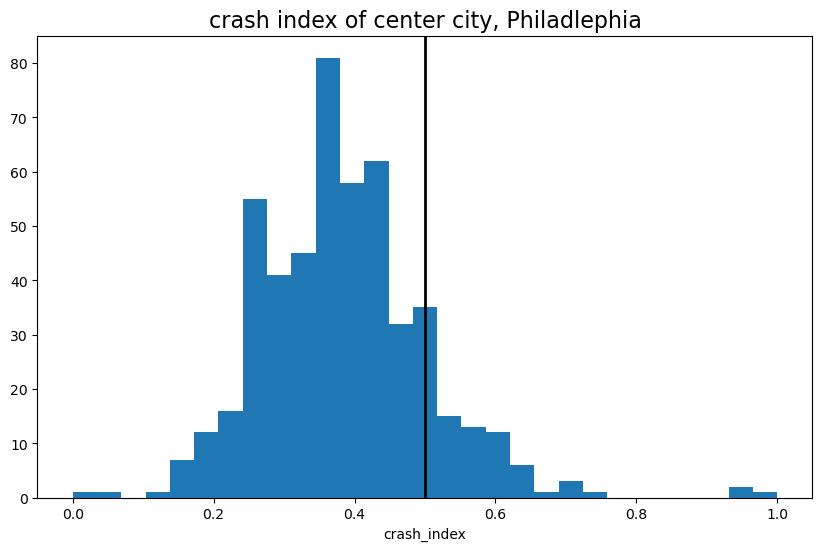

In [136]:
fig, ax = plt.subplots(figsize=(10, 6))

# histogram
ax.hist(stcra["crash_index"], bins="auto")
ax.axvline(x=0.5, c="k", lw=2)

# format
ax.set_xlabel("crash_index")
ax.set_title("crash index of center city, Philadlephia", fontsize=16)

In [138]:
m = stcra.explore(column="crash_index", tiles="Cartodb positron")

m

In [1]:
import pandas as pd